<a href="https://www.kaggle.com/code/annkuruvilla/news-language-model-transformer?scriptVersionId=131000811" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Language Model Using News Data 

Here is a simple  Language model is created using pytorch's  of Transformer Encoder  using a part of the  News Articles (public domain) dataset [https://www.kaggle.com/datasets/asad1m9a9h6mood/news-articles] . This dataset has  both sports and business news.Currently only the sports news section is made use here.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
news=pd.read_csv('/kaggle/input/news-articles/Articles.csv',encoding='cp1252')

<AxesSubplot: >

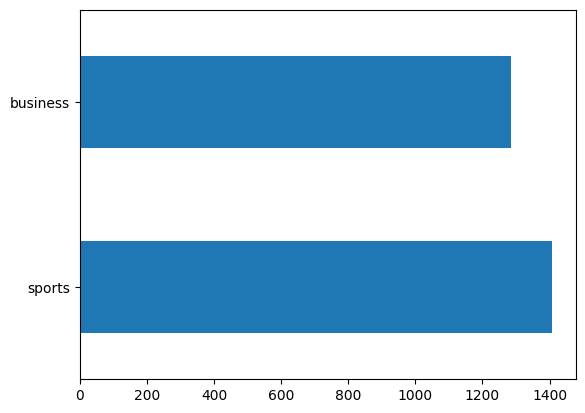

In [3]:
news.NewsType.value_counts().plot.barh()

In [4]:
sports_news=news[news["NewsType"]=='sports']
business_news=news[news["NewsType"]=='business']

In [5]:
print(f'There are {len(sports_news)} sports news and {len(business_news)} business news')

There are 1408 sports news and 1284 business news


In [6]:
sports_list=list(sports_news["Article"])
sports_heading=list(sports_news["Heading"])

business_list=list(business_news["Article"])
business_heading=list(business_news["Heading"])

In [7]:
import re
def split_func(text):
    text=text.lower()
    if ":" in text:
        text=text.split(':')[1]
    text=re.sub(r'[^a-zA-Z0-9\']', ' ', text)    
    return text

In [8]:
sports_article=[split_func(text) for text in sports_list ]
business_article=[split_func(text) for text in business_list]

In [9]:
print(f'There are {len(sports_article)} sports news and {len(business_article)} business news')

There are 1408 sports news and 1284 business news


## Vocabulary

In [10]:
import model_utilities as util

In [11]:
sports_text_list=sports_article
sports_vocab_obj=util.Vocabulary(sports_text_list)
sports_vocab_obj.make_token_dicts()

In [13]:
sports_train_pd=pd.DataFrame(sports_text_list)
sports_train_pd.columns=['text']

## Dataset and DataLoader

In [14]:
def add_pad(token_array,pad_int,total_length):    
    if(total_length>len(token_array)):
        rem_len=total_length-len(token_array)
        pad_positions=np.repeat(pad_int,rem_len) 
        pad_array=np.concatenate([token_array, pad_positions])
        return pad_array
    return token_array

def split_sequence_start_end(text,token2index,seq_len):    
    text_int=[token2index[token] if token in token2index else token2index['<UNK>']  for token in text.split()]  
    start,end=0,len(text_int)+1    
    text_int.insert(start,token2index['<START>'])
    text_int.insert(end,token2index['<END>'])    
    seq_total=len(text_int)    
    num_seqs=seq_total//seq_len    #possible number of full sequences
    if(num_seqs<1):  #cant fulfil one full sequence discard
        return [],[]     
    new_sent=text_int[:num_seqs*seq_len+1]
    inp_text=np.asarray(new_sent[0:num_seqs*seq_len])
    target_text=np.asarray(new_sent[1:num_seqs*seq_len+1])
    
    if(len(inp_text)!=num_seqs*seq_len):
           inp_text=add_pad(inp_text,token2index['<PAD>'],num_seqs*seq_len)
    if(len(target_text)!=num_seqs*seq_len):
           target_text=add_pad(target_text,token2index['<PAD>'],num_seqs*seq_len)
    
    inp_text=inp_text.reshape(num_seqs,seq_len)
    target_text=target_text.reshape(num_seqs,seq_len)
    
    return inp_text.tolist(),target_text.tolist()

In [15]:
def convert_token_2_ints(text,token_dict):
    if(text.strip()):
        text=split_func(text)
        text_int=[token_dict[token] if token in token_dict else token_dict['<UNK>']  for token in text.split()]
        return text_int
    return []

In [16]:
def get_input_targets(text_list,token2index,seq_len):
    input_list=[]
    target_list=[]
    for text in text_list:        
        inp,tgt=split_sequence_start_end(text,token2index,seq_len)
        myt=(len(inp)>0,len(tgt)>0)
        if all(myt):            
            input_list.extend(inp)
            target_list.extend(tgt)            
    return input_list,target_list

In [17]:
seq_len=8
train_inputs,train_targets=get_input_targets(list(sports_train_pd["text"]),sports_vocab_obj.token2index,seq_len=seq_len)
train_tuple=zip(train_inputs, train_targets)
lm_data=pd.DataFrame(list(train_tuple),columns =['input', 'target'])

In [18]:
from torch.utils.data import DataLoader, Dataset

class LMDataset(Dataset):
    def __init__(self,pd_table):
        self.pd_table=pd_table        
          
    def __len__(self):
        return len(self.pd_table)
    
    def __getitem__(self,index):
        row=self.pd_table.iloc[index]
        inp=row['input']
        tgt=row['target']        
        return inp,tgt

In [19]:
def lm_collate(batch):
    input_list = []
    target_list=[]
    for inp, tgt in batch:
        input_list.append(inp)
        target_list.append(tgt)    
    input_list=torch.LongTensor(input_list)
    target_list=torch.LongTensor(target_list)
    return input_list,target_list


In [20]:
batch_size=32
lm_dataset=LMDataset(lm_data)
lm_loader = DataLoader(dataset=lm_dataset,batch_size=batch_size,num_workers=2,shuffle=True,collate_fn=lm_collate)
train_batches=len(lm_dataset)//batch_size
print(f'With a {batch_size} batch size there are {train_batches} train batches')

With a 32 batch size there are 1480 train batches


# Transformer Model

Main model params: Layers=1,Model Size=512, Heads= 8


In [21]:
if torch.cuda.is_available():
    device=torch.device("cuda")
else:
    device=torch.device("cpu")
    
print(device)

cuda


In [22]:
import math

def positional_encodings(positions,d_model,n=10000.0):
    encodings=torch.zeros(positions,d_model)
    divisor=[ math.pow(n,(2*i/d_model)) for i in range(d_model) ]
    def get_code(pos,divisor):
        arr=[math.cos(pos/divisor[i//2]) if i%2 else math.sin(pos/divisor[i//2]) for i in range(d_model) ]
        return torch.FloatTensor(arr)
    for pos in range(positions):
        encodings[pos]=get_code(pos,divisor)
    return encodings

In [23]:
class TransformerEncoderModel(nn.Module):
    def __init__(self,vocab_obj,device,model_size=512,heads=8,layers=2,max_positions=100,drop=0.1):
        super(TransformerEncoderModel,self).__init__()
        self.embedding=nn.Embedding(len(vocab_obj),model_size)
        self.positional_encoding=positional_encodings(max_positions,model_size,n=10000.0).to(device)        
        self.encoder_subblock=nn.TransformerEncoderLayer(d_model=model_size,nhead=heads,dropout=0.5,activation='relu',batch_first=True)
        self.transformer_encoder=nn.TransformerEncoder(self.encoder_subblock, num_layers=layers)
        self.linear_layer=nn.Linear(model_size,len(vocab_obj))        
        self.dropout=nn.Dropout(drop)        
        self.device=device
        
    def forward(self,src_input): 
        batch_size,seq_len=src_input.shape
        embeddings=self.embedding(src_input)   # batch_size,seq_len  
        positional_encodings=self.positional_encoding[:src_input.shape[1]] 
        source_mask=torch.triu(torch.ones(seq_len, seq_len),diagonal=1).bool().to(device)
        out=self.dropout(embeddings+positional_encodings)        
        out = self.transformer_encoder(src=out,mask =source_mask)
        out=self.linear_layer(out)
        return out

In [24]:
def init_model(vocab_obj,device,layers=2,init_func="xavier"):    
    model=TransformerEncoderModel(vocab_obj,device,layers=layers).to(device)    
    if init_func=="xavier":
        for param in model.parameters():
            if(len(param.shape)>=2):
                nn.init.xavier_uniform_(param, gain=nn.init.calculate_gain('relu'))                
    elif init_func=="kaiming":
        for param in model.parameters():
            if(len(param.shape)>=2):
                nn.init.kaiming_normal_(param, mode='fan_out', nonlinearity='relu')
    elif init_func=="uniform":
        for param in model.parameters():
            if(len(param.shape)>=2):
                nn.init.uniform_(param,a=-0.2,b=0.2)
    return model

## Training Parameters

In [25]:
vocab_obj=sports_vocab_obj.token2index #vocabulary
loss_function=nn.CrossEntropyLoss() #Loss Function
model=init_model(vocab_obj,device,layers=1,init_func="xavier").to(device) #Model
optimizer = torch.optim.AdamW(model.parameters(),lr=0.001)  #optimiser
epochs=40 #epochs

## Training

In [26]:
from tqdm import tqdm

In [27]:
loss_dict={}
for index in range(epochs):  
    model.train()        
    epoch_train_loss=0
    total_train_size=0   
    train_accuracy=0
    lm_train=tqdm(lm_loader,desc='Training LM')
        
    for batch_id,(input,target) in enumerate(lm_train):
            optimizer.zero_grad()            
            input=input.to(device)            
            target=target.to(device)
            out=model(input) 
            out=out.reshape(-1,len(vocab_obj))
            target=target.reshape(-1)            
            loss=loss_function(out,target)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(),max_norm=0.5,error_if_nonfinite=True) 
            optimizer.step()              
            epoch_train_loss+=loss.item() 
            
    loss_value=float(1.0*epoch_train_loss)/train_batches  
    loss_dict[index]=loss_value    
    lm_train.set_description(f"Training  [{index}/{epochs}] ")
    

Training LM: 100%|██████████| 1481/1481 [00:18<00:00, 79.18it/s]


<AxesSubplot: >

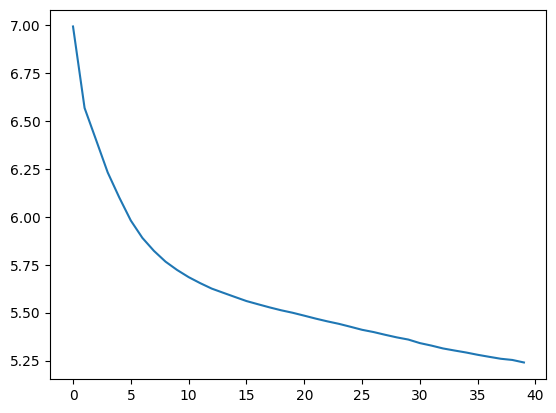

In [28]:
loss_list=[]
for x,y in loss_dict.items():
    loss_list.append(y)
    
sns.lineplot(data= pd.Series(loss_list))

## Inference Strategies

1. Greedy Inference  : No starting prompt
2. Greedy Inference :  With a starting prompt
3. Top P / Nucleus Sampling: No starting prompt


In [29]:
def convert_token_to_text(result,reverse_dict):    
    for sent in results[:,1:].tolist():
        text_list=[]
        for token in sent:
            text_list.append(reverse_dict[token])            
    return " ".join(text_list)
    

In [30]:
def greedy_inference_noPrompt(model,vocab_dict,batch_size=5,sent_max_len=8,device=device):
    start_batch=torch.full((batch_size,1),vocab_dict['<START>']).to(device)    
    current_tokens=start_batch
    req_len=1
    while(req_len<=sent_max_len):
        output=model(current_tokens)
        predict_tokens=torch.argmax(output[:,-1,:],dim=-1).reshape(batch_size,1)        
        current_tokens=torch.cat((current_tokens,predict_tokens),1)
        req_len=req_len+1
    return current_tokens

In [31]:
def greedy_inference_withPrompt(model,prompt,vocab_dict,sent_max_len=8,device=device):
    prompt=convert_token_2_ints(prompt,vocab_dict)    
    prompt.insert(0,vocab_dict['<START>'])
    current_tokens=torch.LongTensor(prompt).reshape(1,-1).to(device)
    req_len=1
    while(req_len<=sent_max_len):
        output=model(current_tokens)
        predict_tokens=torch.argmax(output[:,-1,:],dim=-1).reshape(1,1)        
        current_tokens=torch.cat((current_tokens,predict_tokens),1)
        req_len=req_len+1
    return current_tokens

In [32]:
def nucleus_sampling(vocab_distrib,p=1.0,T=1):
    neg_inf=-float('inf')
    vocab_distrib_temp=F.softmax(vocab_distrib/T,dim=-1)
    sorted_vals, indices = torch.sort(vocab_distrib_temp,descending=True)
    temp,total=0,p
    main_indices=[]
    for val,index in zip(sorted_vals,indices):        
        temp=temp+val
        if temp>total:
            break
        main_indices.append(index)        
    
    inf_list=[i.item() for i in indices[len(main_indices):]]
    for ind in inf_list:        
        vocab_distrib[ind]=neg_inf
        
    return F.softmax(vocab_distrib/T,dim=-1)

In [33]:
def nucleus_sampling_noPrompt(model,vocab_dict,p=1.0,T=1,sent_max_len=10,device=device):
    start_batch=torch.full((1,1),vocab_dict['<START>']).to(device)
    vocab_size=len(vocab_dict)
    current_tokens=start_batch
    req_len=1
    while(req_len<=sent_max_len):
        output=model(current_tokens)
        vocab_distrib=output[0,-1,:].reshape(-1)        
        sampled_vocab=nucleus_sampling(vocab_distrib,p,T)
        sampled_vocab=sampled_vocab.reshape(1,vocab_size)
        
        predict_tokens=torch.multinomial(sampled_vocab, 1)
        current_tokens=torch.cat((current_tokens,predict_tokens),1)
        req_len=req_len+1
        
    return current_tokens

Greedy Inference : No starting prompt


In [84]:
results=greedy_inference_noPrompt(model,sports_vocab_obj.token2index)
convert_token_to_text(results,sports_vocab_obj.index2token)

'strong the first innings of the first test'

Greedy Inference : With a starting prompt


In [120]:
prompt="indian cricket team"
results=greedy_inference_withPrompt(model,prompt,sports_vocab_obj.token2index)
convert_token_to_text(results,sports_vocab_obj.index2token)

'indian cricket team to win in the first innings of the'

Top P / Nucleus Sampling: No starting prompt

In [297]:
results=nucleus_sampling_noPrompt(model,sports_vocab_obj.token2index,p=0.9,T=0.9,sent_max_len=8)
convert_token_to_text(results,sports_vocab_obj.index2token)

'cut his golden start in the games at'

* More work to be done on the inferencing part

## Useful References:
* https://pytorch.org/tutorials/beginner/transformer_tutorial.html
* https://huggingface.co/blog/how-to-generate